Normalizing Flows Implementation for Fashion-MNIST Generation

This module implements a normalizing flow model using affine coupling layers to learn the data distribution of Fashion-MNIST images.  
The model transforms data between the data space and a simple base distribution (standard Gaussian).  

Key components:
- CouplingLayer: Implements affine transformations with learnable scale/shift
- FlowSequential: Chains multiple invertible transformations
- Training pipeline with proper validation and early stopping

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from torch import Tensor
from typing import Tuple, Callable
from itertools import chain
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler
from torch.distributions import MultivariateNormal
from models.mlp import MLP
from models.lambda_layer import (
    LambdaLayer,
    img_to_vec,
    vec_to_img,
    add_noise,
    sigmoid_inverse
)
from flows.coupling_layers import CouplingLayer
from flows.flow_models import FlowSequential
from utils.trainer import train_flow
from utils.checkpoint import load_model
from utils.visualization import plot_losses

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

scaler = GradScaler(device)

Using cuda device


/tmp/ipykernel_62865/3266725043.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(device)


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    # download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    # download=True,
    transform=ToTensor(),
)

In [4]:
# Filter for single class (T-shirts/tops) for simpler learning
target_label = 0
training_data_incides = torch.where(training_data.targets == target_label)[0]
test_data_incides = torch.where(test_data.targets == target_label)[0]

training_data = Subset(training_data, training_data_incides)
test_data = Subset(test_data, test_data_incides)

In [5]:
# Train/validation split
val_fraction = 0.1
dataset_size = len(training_data)
val_size = int(val_fraction * dataset_size)
train_size = dataset_size - val_size

# Create a reproducible shuffled list of indices
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(dataset_size, generator=generator).tolist()

# Split indices for train and validation
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Wrap Subsets for train and validation datasets
train_data = Subset(training_data, train_indices)
val_data = Subset(training_data, val_indices)

In [6]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(f"Training batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64
Training batches: 47
Test batches: 8


In [7]:
# For implementation challange
NORMAL_DIST_CONST = torch.log(torch.tensor(2 * torch.pi, device=device))
def normal_NLL(X: Tensor) -> Tensor:
    """Compute -log p(z) for standard Gaussian"""
    d = X.shape[1]
    const_term = (d / 2) * NORMAL_DIST_CONST.to(X.device)
    squared_term = 0.5 * X.pow(2).sum(dim=1)
    return const_term + squared_term


def flow_NLL_loss(
    z_sample: Tensor,
    total_log_det: Tensor,
) -> Tensor:
    """Flow loss = base NLL - total log det (averaged)"""
    return torch.mean(normal_NLL(z_sample) - total_log_det)

In [8]:
flow_net = FlowSequential(
    784, # 28*28 flattened image
    [
        LambdaLayer(img_to_vec, vec_to_img), # Flatten image
        LambdaLayer(add_noise, lambda x: x), # Dequantization
        LambdaLayer(sigmoid_inverse, torch.sigmoid),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device)),
        CouplingLayer(392, MLP([392, 512, 512, 392], device = device), MLP([392, 512, 512, 392], device = device), True),
    ]

).to(device)


In [9]:
# Test forward pass
x_sample = next(iter(train_dataloader))[0].to(device)
x_to_z = flow_net(x_sample, 0)

100%|██████████| 5/5 [00:00<00:00, 95.99it/s]


Epoch 1 completed. Train Loss: 25522481459.1581, Val Loss: 1906.0858 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 105.34it/s]


Epoch 2 completed. Train Loss: 1662.7602, Val Loss: 1528.6815 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 100.33it/s]


Epoch 3 completed. Train Loss: 1472.6134, Val Loss: 1410.5867 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 91.90it/s]


Epoch 4 completed. Train Loss: 1365.4174, Val Loss: 1327.5554 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 101.28it/s]


Epoch 5 completed. Train Loss: 1304.3128, Val Loss: 1280.5219 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 88.19it/s]


Epoch 6 completed. Train Loss: 1263.8631, Val Loss: 1245.2679 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 102.38it/s]


Epoch 7 completed. Train Loss: 1231.3803, Val Loss: 1216.4553 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 101.63it/s]


Epoch 8 completed. Train Loss: 1208.5006, Val Loss: 1197.0468 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 79.51it/s]


Epoch 9 completed. Train Loss: 1190.7150, Val Loss: 1180.6094 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 98.39it/s]


Epoch 10 completed. Train Loss: 1173.4028, Val Loss: 1162.6037 # NEW BEST MODEL #


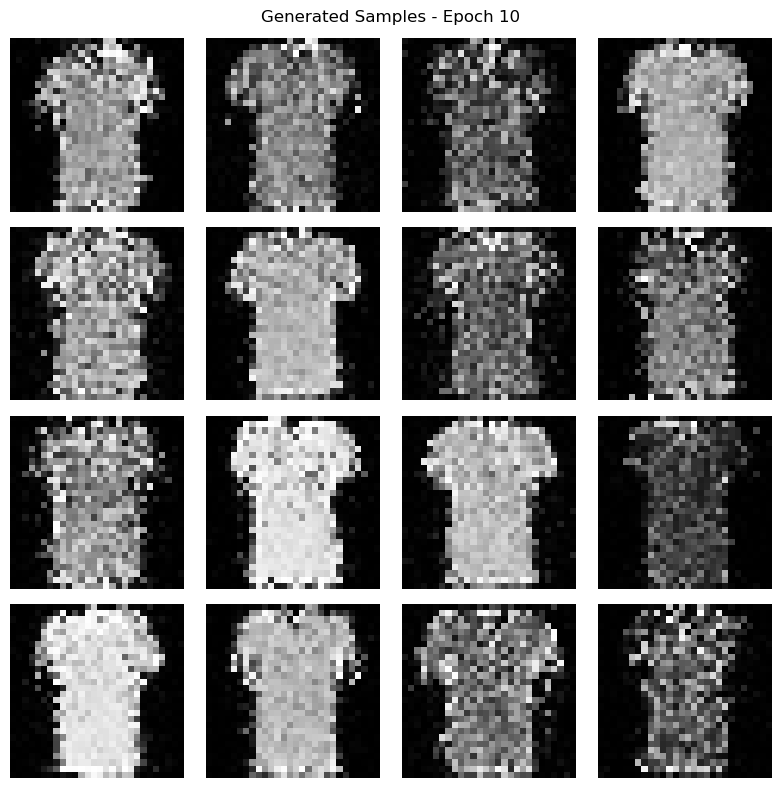

100%|██████████| 5/5 [00:00<00:00, 82.86it/s]


Epoch 11 completed. Train Loss: 1158.8001, Val Loss: 1149.3650 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 77.95it/s]


Epoch 12 completed. Train Loss: 1146.9030, Val Loss: 1139.2572 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 84.17it/s]


Epoch 13 completed. Train Loss: 1134.8226, Val Loss: 1126.1781 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 98.57it/s]


Epoch 14 completed. Train Loss: 1123.0219, Val Loss: 1116.0434 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 78.04it/s]


Epoch 15 completed. Train Loss: 1112.4087, Val Loss: 1107.2978 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 92.35it/s]


Epoch 16 completed. Train Loss: 1101.9897, Val Loss: 1098.5950 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 90.32it/s]


Epoch 17 completed. Train Loss: 1093.3693, Val Loss: 1086.9896 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 96.19it/s]


Epoch 18 completed. Train Loss: 1083.7822, Val Loss: 1076.1783 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 79.33it/s]


Epoch 19 completed. Train Loss: 1075.1586, Val Loss: 1070.6526 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 101.58it/s]


Epoch 20 completed. Train Loss: 1065.9844, Val Loss: 1059.9299 # NEW BEST MODEL #


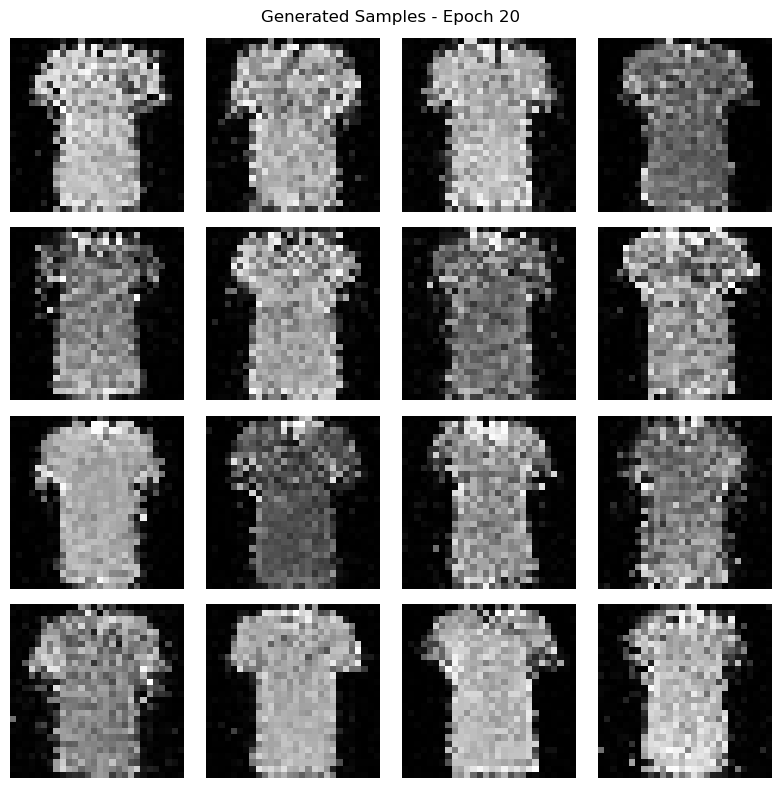

100%|██████████| 5/5 [00:00<00:00, 103.05it/s]


Epoch 21 completed. Train Loss: 1054.1615, Val Loss: 1048.1381 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 90.18it/s]


Epoch 22 completed. Train Loss: 1048.0962, Val Loss: 1045.0073 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 98.02it/s]


Epoch 23 completed. Train Loss: 1043.4461, Val Loss: 1040.4700 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 99.21it/s]


Epoch 24 completed. Train Loss: 1038.5408, Val Loss: 1035.6486 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 88.27it/s]


Epoch 25 completed. Train Loss: 1034.0765, Val Loss: 1028.5147 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 101.60it/s]


Epoch 26 completed. Train Loss: 1029.2533, Val Loss: 1026.8070 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 87.79it/s]


Epoch 27 completed. Train Loss: 1024.5107, Val Loss: 1020.0880 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 102.76it/s]


Epoch 28 completed. Train Loss: 1021.2847, Val Loss: 1016.1902 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 105.56it/s]


Epoch 29 completed. Train Loss: 1016.8764, Val Loss: 1012.3442 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 90.48it/s]


Epoch 30 completed. Train Loss: 1012.8299, Val Loss: 1008.0329 # NEW BEST MODEL #


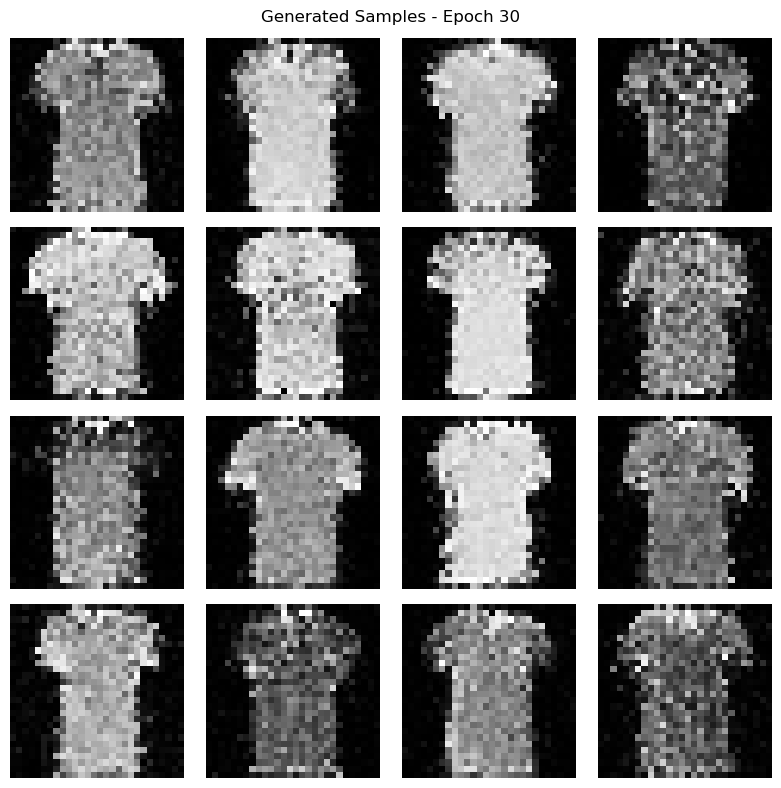

100%|██████████| 5/5 [00:00<00:00, 94.65it/s]


Epoch 31 completed. Train Loss: 1008.6458, Val Loss: 1003.0969 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 97.25it/s]


Epoch 32 completed. Train Loss: 1005.3529, Val Loss: 1000.4443 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 77.42it/s]


Epoch 33 completed. Train Loss: 1001.1117, Val Loss: 998.8471 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 95.31it/s]


Epoch 34 completed. Train Loss: 997.9982, Val Loss: 994.0318 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 86.32it/s]


Epoch 35 completed. Train Loss: 993.0671, Val Loss: 991.5374 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 90.71it/s]


Epoch 36 completed. Train Loss: 989.8932, Val Loss: 986.0034 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 94.37it/s]


Epoch 37 completed. Train Loss: 987.9499, Val Loss: 982.1681 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 68.47it/s]


Epoch 38 completed. Train Loss: 983.4298, Val Loss: 980.2269 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 84.34it/s]


Epoch 39 completed. Train Loss: 980.5498, Val Loss: 977.5300 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 95.52it/s]


Epoch 40 completed. Train Loss: 977.5422, Val Loss: 971.9543 # NEW BEST MODEL #


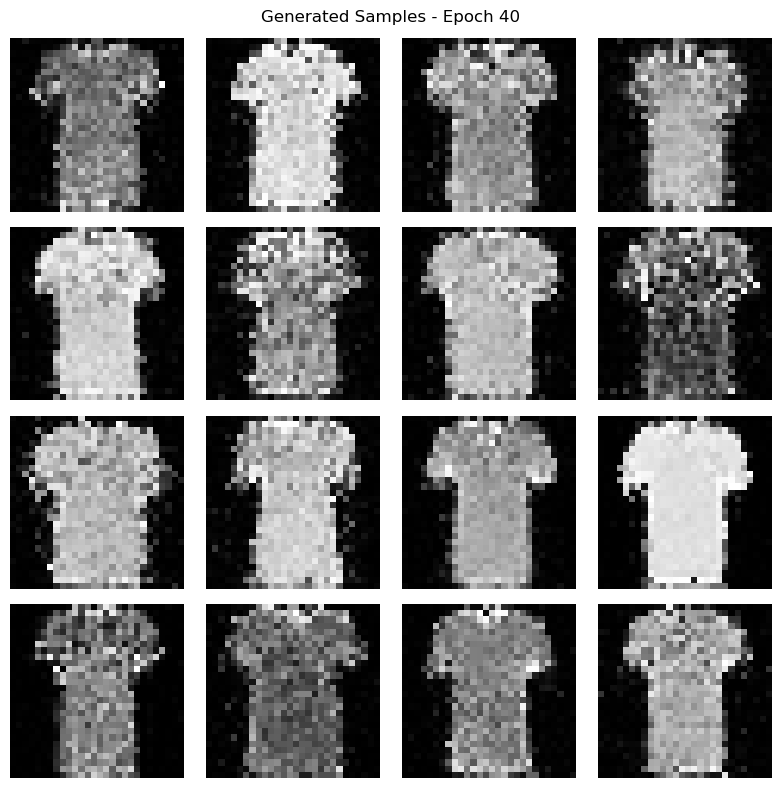

100%|██████████| 5/5 [00:00<00:00, 97.51it/s]


Epoch 41 completed. Train Loss: 970.9206, Val Loss: 970.4576 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 80.75it/s]


Epoch 42 completed. Train Loss: 968.6693, Val Loss: 966.6935 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 92.08it/s]


Epoch 43 completed. Train Loss: 966.5456, Val Loss: 964.2456 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 90.39it/s]


Epoch 44 completed. Train Loss: 964.4548, Val Loss: 960.7729 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 94.43it/s]


Epoch 45 completed. Train Loss: 962.7162, Val Loss: 960.8003 (Best: 960.7729 at epoch 44)


100%|██████████| 5/5 [00:00<00:00, 92.89it/s]


Epoch 46 completed. Train Loss: 961.0547, Val Loss: 955.5813 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 87.80it/s]


Epoch 47 completed. Train Loss: 959.2929, Val Loss: 955.0354 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 94.40it/s]


Epoch 48 completed. Train Loss: 956.8382, Val Loss: 953.8880 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 90.86it/s]


Epoch 49 completed. Train Loss: 955.7435, Val Loss: 953.0087 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 98.67it/s]


Epoch 50 completed. Train Loss: 953.5149, Val Loss: 951.2459 # NEW BEST MODEL #


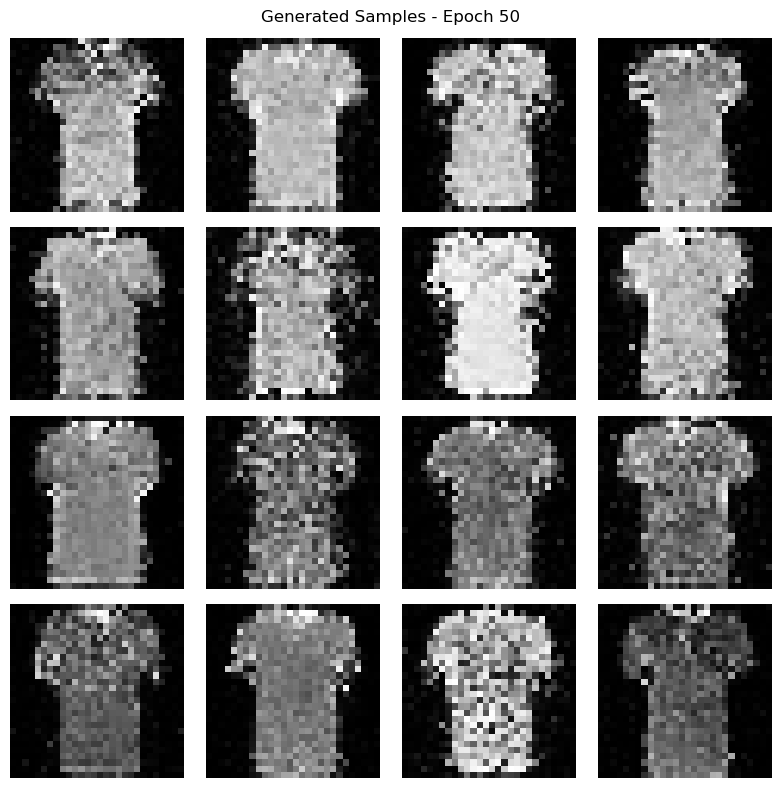

100%|██████████| 5/5 [00:00<00:00, 93.56it/s]


Epoch 51 completed. Train Loss: 951.4489, Val Loss: 946.7387 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 101.52it/s]


Epoch 52 completed. Train Loss: 950.1474, Val Loss: 947.0445 (Best: 946.7387 at epoch 51)


100%|██████████| 5/5 [00:00<00:00, 100.44it/s]


Epoch 53 completed. Train Loss: 948.1643, Val Loss: 947.5566 (Best: 946.7387 at epoch 51)


100%|██████████| 5/5 [00:00<00:00, 97.66it/s]


Epoch 54 completed. Train Loss: 947.2794, Val Loss: 943.8970 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 96.20it/s]


Epoch 55 completed. Train Loss: 945.5068, Val Loss: 945.2945 (Best: 943.8970 at epoch 54)


100%|██████████| 5/5 [00:00<00:00, 100.65it/s]


Epoch 56 completed. Train Loss: 944.0530, Val Loss: 942.9119 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 88.18it/s]


Epoch 57 completed. Train Loss: 942.0063, Val Loss: 939.7337 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 103.31it/s]


Epoch 58 completed. Train Loss: 940.5692, Val Loss: 935.4644 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 99.89it/s]


Epoch 59 completed. Train Loss: 938.7377, Val Loss: 938.5414 (Best: 935.4644 at epoch 58)


100%|██████████| 5/5 [00:00<00:00, 98.28it/s]


Epoch 60 completed. Train Loss: 937.7543, Val Loss: 936.9316 (Best: 935.4644 at epoch 58)


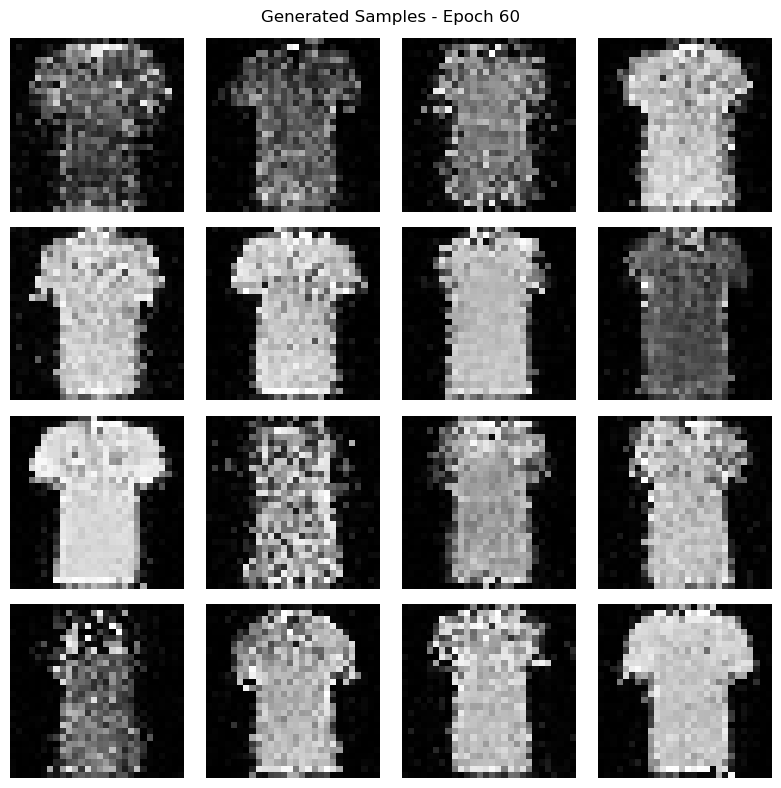

100%|██████████| 5/5 [00:00<00:00, 88.53it/s]


Epoch 61 completed. Train Loss: 934.5964, Val Loss: 930.4161 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 103.80it/s]


Epoch 62 completed. Train Loss: 934.1309, Val Loss: 933.2462 (Best: 930.4161 at epoch 61)


100%|██████████| 5/5 [00:00<00:00, 98.08it/s]


Epoch 63 completed. Train Loss: 931.7919, Val Loss: 931.0647 (Best: 930.4161 at epoch 61)


100%|██████████| 5/5 [00:00<00:00, 94.01it/s]


Epoch 64 completed. Train Loss: 930.0866, Val Loss: 929.9028 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 84.72it/s]


Epoch 65 completed. Train Loss: 930.2210, Val Loss: 926.0066 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 107.24it/s]


Epoch 66 completed. Train Loss: 929.2864, Val Loss: 927.8450 (Best: 926.0066 at epoch 65)


100%|██████████| 5/5 [00:00<00:00, 102.94it/s]


Epoch 67 completed. Train Loss: 928.3671, Val Loss: 925.4732 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 81.37it/s]


Epoch 68 completed. Train Loss: 927.0718, Val Loss: 926.5418 (Best: 925.4732 at epoch 67)


100%|██████████| 5/5 [00:00<00:00, 78.80it/s]


Epoch 69 completed. Train Loss: 926.1639, Val Loss: 925.5361 (Best: 925.4732 at epoch 67)


100%|██████████| 5/5 [00:00<00:00, 89.57it/s]


Epoch 70 completed. Train Loss: 926.0514, Val Loss: 925.3659 # NEW BEST MODEL #


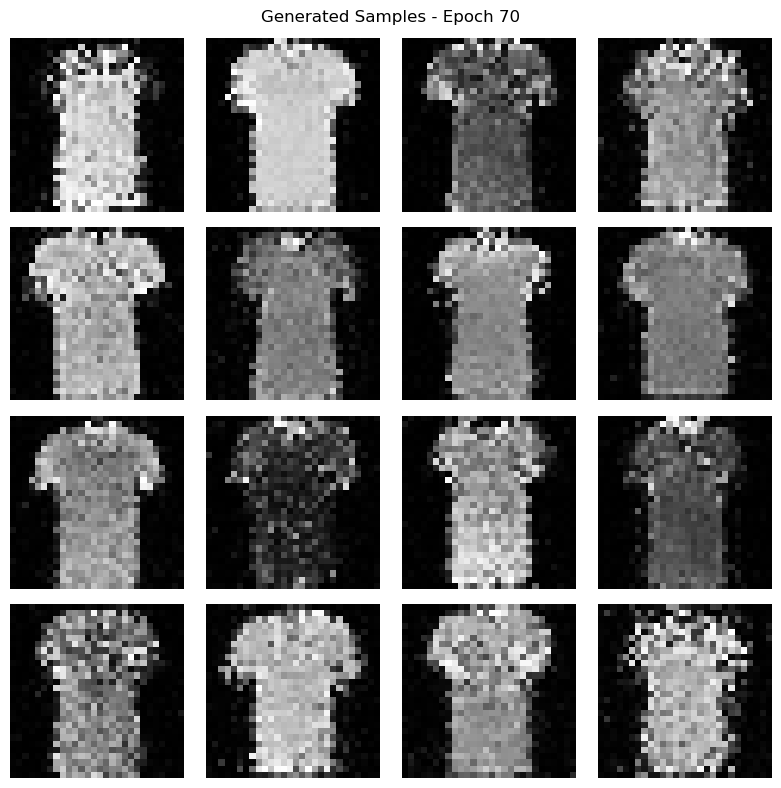

100%|██████████| 5/5 [00:00<00:00, 100.02it/s]


Epoch 71 completed. Train Loss: 924.9944, Val Loss: 923.5674 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 97.59it/s]


Epoch 72 completed. Train Loss: 923.2604, Val Loss: 923.1991 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 96.61it/s]


Epoch 73 completed. Train Loss: 923.0203, Val Loss: 920.6213 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 91.80it/s]


Epoch 74 completed. Train Loss: 922.1178, Val Loss: 918.9218 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 103.85it/s]


Epoch 75 completed. Train Loss: 921.7940, Val Loss: 921.5593 (Best: 918.9218 at epoch 74)


100%|██████████| 5/5 [00:00<00:00, 90.37it/s]


Epoch 76 completed. Train Loss: 920.3125, Val Loss: 919.4400 (Best: 918.9218 at epoch 74)


100%|██████████| 5/5 [00:00<00:00, 91.89it/s]


Epoch 77 completed. Train Loss: 919.5529, Val Loss: 916.6824 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 95.53it/s]


Epoch 78 completed. Train Loss: 919.5006, Val Loss: 917.4290 (Best: 916.6824 at epoch 77)


100%|██████████| 5/5 [00:00<00:00, 94.12it/s]


Epoch 79 completed. Train Loss: 918.7679, Val Loss: 918.3667 (Best: 916.6824 at epoch 77)


100%|██████████| 5/5 [00:00<00:00, 92.01it/s]


Epoch 80 completed. Train Loss: 917.6810, Val Loss: 915.4073 # NEW BEST MODEL #


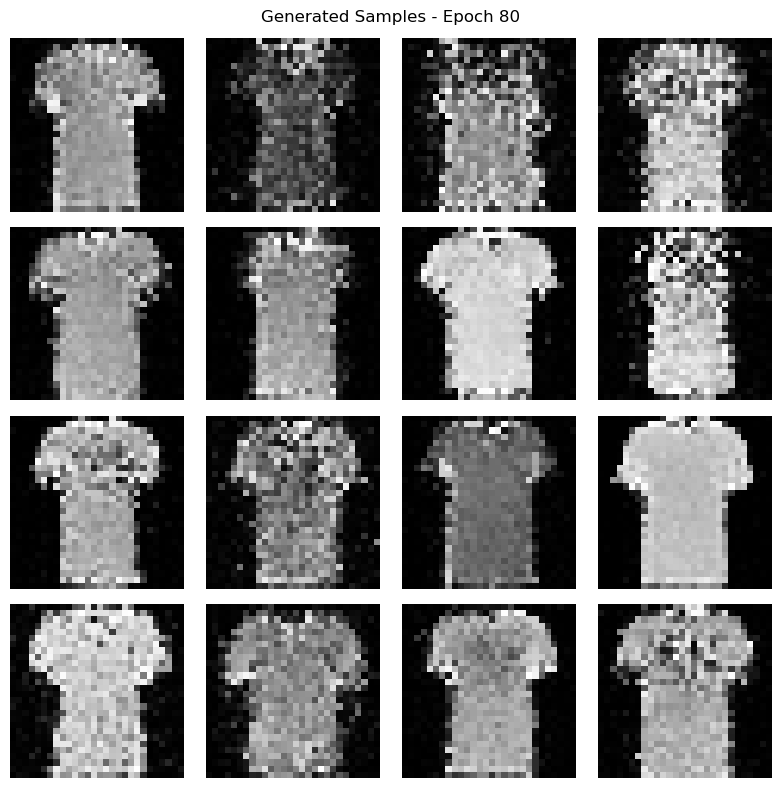

100%|██████████| 5/5 [00:00<00:00, 100.36it/s]


Epoch 81 completed. Train Loss: 915.5730, Val Loss: 915.1877 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 89.23it/s]


Epoch 82 completed. Train Loss: 916.0155, Val Loss: 914.2237 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 88.48it/s]


Epoch 83 completed. Train Loss: 914.7734, Val Loss: 916.2635 (Best: 914.2237 at epoch 82)


100%|██████████| 5/5 [00:00<00:00, 95.01it/s]


Epoch 84 completed. Train Loss: 914.9632, Val Loss: 913.7114 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 87.05it/s]


Epoch 85 completed. Train Loss: 913.7804, Val Loss: 915.0201 (Best: 913.7114 at epoch 84)


100%|██████████| 5/5 [00:00<00:00, 97.58it/s]


Epoch 86 completed. Train Loss: 913.0938, Val Loss: 912.4896 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 95.43it/s]


Epoch 87 completed. Train Loss: 913.0426, Val Loss: 909.7803 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 94.33it/s]


Epoch 88 completed. Train Loss: 912.9848, Val Loss: 911.6053 (Best: 909.7803 at epoch 87)


100%|██████████| 5/5 [00:00<00:00, 79.83it/s]


Epoch 89 completed. Train Loss: 912.2080, Val Loss: 912.6256 (Best: 909.7803 at epoch 87)


100%|██████████| 5/5 [00:00<00:00, 93.10it/s]


Epoch 90 completed. Train Loss: 911.6435, Val Loss: 911.6344 (Best: 909.7803 at epoch 87)


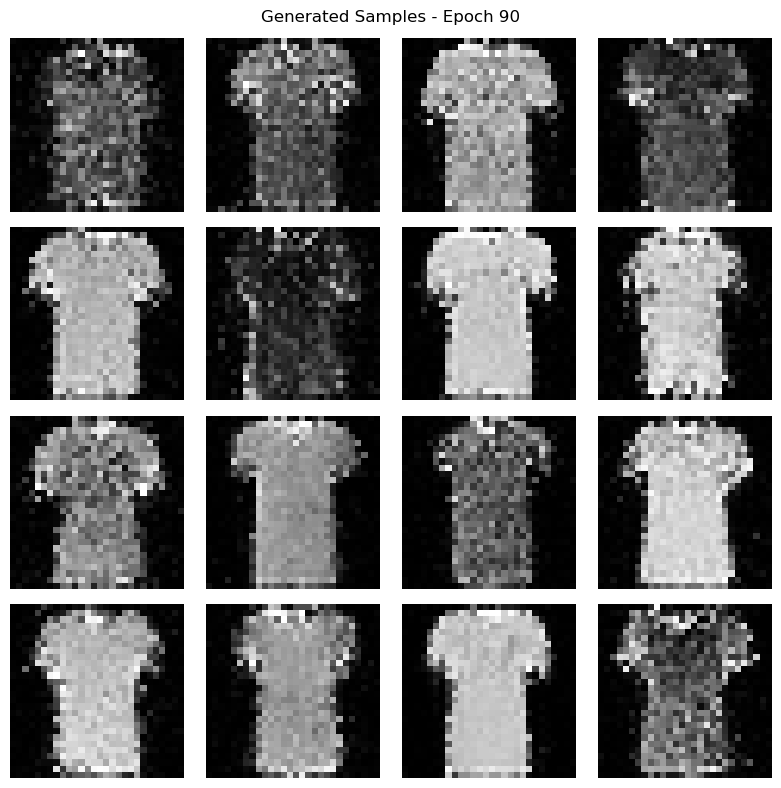

100%|██████████| 5/5 [00:00<00:00, 90.83it/s]


Epoch 91 completed. Train Loss: 910.9797, Val Loss: 910.5791 (Best: 909.7803 at epoch 87)


100%|██████████| 5/5 [00:00<00:00, 91.37it/s]


Epoch 92 completed. Train Loss: 911.6718, Val Loss: 911.8435 (Best: 909.7803 at epoch 87)


100%|██████████| 5/5 [00:00<00:00, 98.48it/s]


Epoch 93 completed. Train Loss: 910.6714, Val Loss: 908.4451 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 98.34it/s]


Epoch 94 completed. Train Loss: 909.6933, Val Loss: 908.2417 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 93.61it/s]


Epoch 95 completed. Train Loss: 909.6808, Val Loss: 908.6081 (Best: 908.2417 at epoch 94)


100%|██████████| 5/5 [00:00<00:00, 77.14it/s]


Epoch 96 completed. Train Loss: 909.6781, Val Loss: 908.0786 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 94.14it/s]


Epoch 97 completed. Train Loss: 908.3876, Val Loss: 906.0183 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 95.55it/s]


Epoch 98 completed. Train Loss: 909.0172, Val Loss: 905.8707 # NEW BEST MODEL #


100%|██████████| 5/5 [00:00<00:00, 78.22it/s]


Epoch 99 completed. Train Loss: 908.3384, Val Loss: 905.8878 (Best: 905.8707 at epoch 98)


100%|██████████| 5/5 [00:00<00:00, 97.48it/s]


Epoch 100 completed. Train Loss: 908.7093, Val Loss: 908.3579 (Best: 905.8707 at epoch 98)


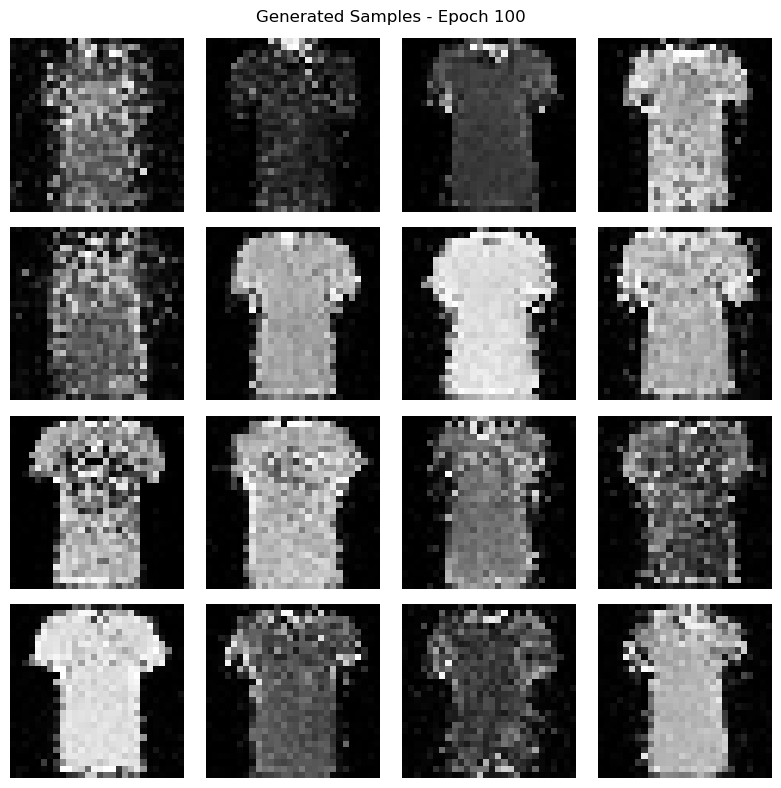

In [10]:
model_save_path = '../models/coupling_model.pth'
train_losses, val_losses = train_flow(
    flow_net, train_dataloader, val_dataloader, device,
    num_epochs=100, lr=1e-4, save_path=model_save_path)

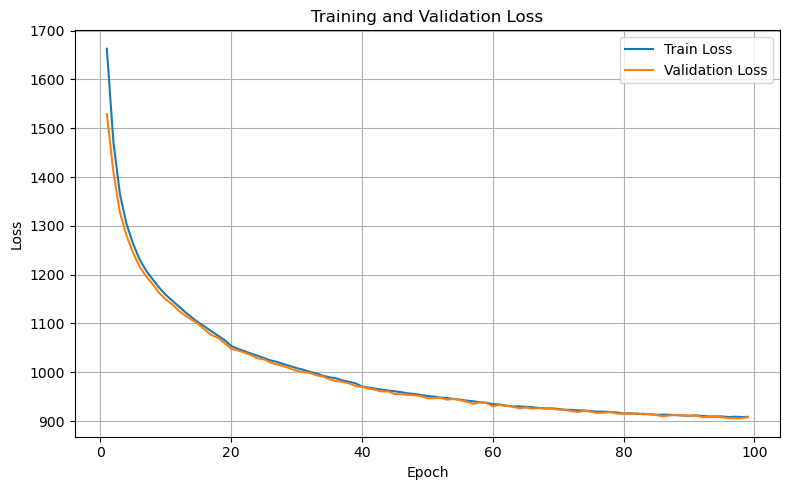

In [16]:
plot_losses(train_losses[1:], val_losses[1:])

In [12]:
# Test reconstruction quality
def test_reconstruction(
    model: nn.modules,
    test_dataloader: DataLoader,
    device: str,
    num_samples: int = 8
):
    """Test reconstruction quality by encoding and decoding real images."""
    model.eval()
    with torch.no_grad():
        # Get a batch of real data
        real_data, _ = next(iter(test_dataloader))
        real_data = real_data[:num_samples].to(device)
        
        # Forward pass to latent space
        z, _ = model.forward(real_data)
        
        # Reconstruct
        reconstructed = model.inverse(z)
        
        # Convert back to images
        real_images = real_data.squeeze(1).cpu()
        reconstructed_images = reconstructed.cpu()
        
        # Visualize
        fig, axes = plt.subplots(2, num_samples, figsize=(12, 4))
        for i in range(num_samples):
            axes[0, i].imshow(real_images[i], cmap='gray')
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(reconstructed_images[i], cmap='gray')
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    model.train()


Loaded model from epoch 98 with validation loss: 905.8707


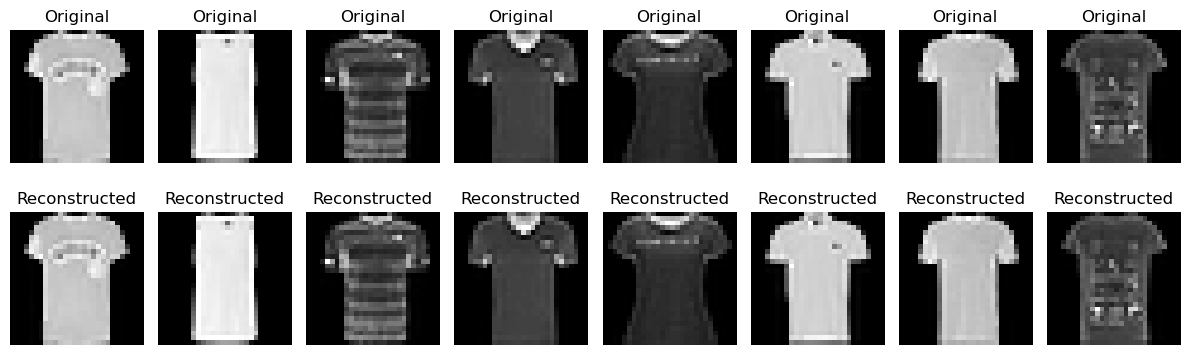

In [ ]:
flow_net = load_model(flow_net, model_save_path, device)
test_reconstruction(flow_net, test_dataloader, device)